In [ ]:
#How to choose an appropriate Prior
#subjective vs objective priors

#objective priors aim to allow the data to influence the posterior the most
#subjective priors allow the practitioner to impute their view into priors

#We've used an objective prior already with "flat" priors
#These are uniform distributions over the entire range of unknowns
#Principle of indifference assigns equal probability to each possible value

#Rarely is an objective prior truly objective



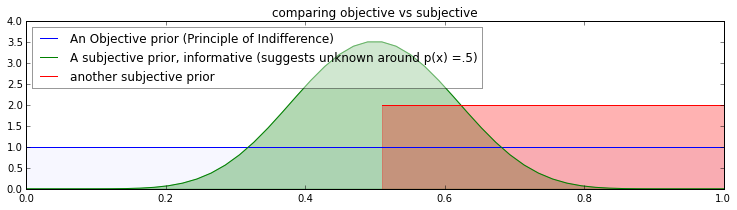

In [3]:
%matplotlib inline
import numpy as np
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import scipy.stats as stats

figsize(12.5,3)
colors = ["#348ABD", "#A60628", "#7A68A6", "#467821"]

x = np.linspace(0,1)
y1,y2 = stats.beta.pdf(x, 1, 1), stats.beta.pdf(x, 10,10)

p = plt.plot(x,y1, label="An Objective prior (Principle of Indifference)")
plt.fill_between(x, 0, y1, color=p[0].get_color(), alpha=.03)

p = plt.plot(x, y2, label="A subjective prior, informative (suggests unknown around p(x) =.5)")
plt.fill_between(x, 0, y2, color = p[0].get_color(), alpha = 0.3 )

p = plt.plot(x[25:], 2*np.ones(25), label="another subjective prior")
plt.fill_between(x[25:], 0, 2, color=p[0].get_color(), alpha = 0.3)

plt.ylim(0,4)
leg = plt.legend(loc='upper left')
leg.get_frame().set_alpha(0.4)
plt.title("comparing objective vs subjective")